# The HFM library - A fast marching solver with adaptive stencils

## Part : Application examples
## Chapter : Tubular structure segmentation


We illustrate several approaches of using the fast marching algorithm for the segmentation of vessels in a medical image. In particular, techniques such as dimension lifting and curvature penalization are demonstrated. The segmentation of tubular structures in images is a domain of research in itself, on which the author only has moderate expertise, hence this notebook has no pretention to be exhaustive or state of the art. It should only be regarded as an advanced demo of the HFM library.

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Preliminary image filtering](#1.-Preliminary-image-filtering)
    * [1.1 Gabor-like filters](#1.1-Gabor-like-filters)
    * [1.2 Maximization over radii and/or orientations](#1.2-Maximization-over-radii-and/or-orientations)
  * [2. Isotropic models](#2.-Isotropic-models)
    * [2.1 Planar shortest paths](#2.1-Planar-shortest-paths)
    * [2.2 Radius lifted metrics](#2.2-Radius-lifted-metrics)
    * [2.3 Gray-level consistency](#2.3-Gray-level-consistency)
  * [3. Curvature penalized models](#3.-Curvature-penalized-models)
    * [3.1 The Reeds-Shepp model](#3.1-The-Reeds-Shepp-model)
    * [3.2 The Euler-Mumford elastica model](#3.2-The-Euler-Mumford-elastica-model)
  * [4. Other models](#4.-Other-models)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Preliminary imports


### 0.1 Required libraries

We begin by setting up the environnement for calling the Hamiltonian-Fast-Marching (HFM) library, importing a few additional libraries, and defining some commodity functions.

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Tubular','FMM'))

In [2]:
from agd import Eikonal
from agd import Metrics
from agd.Plotting import savefig; #savefig.dirName = 'Figures/Tubular'
from agd import AutomaticDifferentiation as ad

In [3]:
import numpy as np; xp=np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Plots geodesics
from scipy import ndimage
from itertools import groupby
from copy import deepcopy
import matplotlib.image

In [4]:
# Commodity functions
def DeleteConsecutiveDuplicates(L): 
    return np.array([x[0] for x in groupby(L, lambda x:tuple(x))])
def MyArgmin(positions,indices,cost,lvl):
    return np.array([(x,y,lvl[np.argmin(cost[i,j,:])]) for ((x,y),(i,j)) in zip(positions,indices)])

In [5]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,Metrics
    Eikonal,Metrics = rreload([Eikonal,Metrics],rootdir="../..")
    Eikonal.dictIn.default_mode = eikonal_mode
    ad.array.caster = lambda x:cupy.asarray(x,dtype=np.float32)

### 0.1 Optional configuration
Uncomment the following line to use the GPU eikonal solver

In [6]:
#Eikonal.dictIn.default_mode = 'gpu_transfer'

Alternatively, with a recent version of cupy

In [7]:
#xp,plt,ndimage,Eikonal = map(ad.cupy_friendly,(xp,plt,ndimage,Eikonal))

### 0.2 Import the image to be processed

Several options are available to import images to be further processed by a Python script. 
Matplotlib provides the simplest approach, but on the author's computer it fails if the imported image is simultanously non-PNG, and internet-downloaded. In that case, the PIL library provides a workaround.

In [8]:
local_path = 'TestImages/subImHRF31_preview.png'
web_path = 'https://github.com/Mirebeau/AdaptiveGridDiscretizations/blob/master/Notebooks_FMM/TestImages/subImHRF31_preview.png?raw=true'

try: image0 = matplotlib.image.imread(local_path)
except FileNotFoundError: image0 = matplotlib.image.imread(web_path)

/var/folders/my/8txl5p_52rj9jc_601wqr7cr0000gn/T/ipykernel_93074/3677320858.py:5: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  except FileNotFoundError: image0 = matplotlib.image.imread(web_path)


In [9]:
# Alternative internet import. Useful in case matplotlib fails, typically for non-png images downloaded over the internet.
#import requests
#import PIL.Image
#from io import BytesIO
#response = requests.get(
#    'https://rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/Images/subImHRF31_preview.jpg') # JPG extension
#image0 = np.array(PIL.Image.open(BytesIO(response.content)))

In this notebook, the processed image is assumed to be in grayscale, with intensity values rescaled to the interval [0,1]. 

In [10]:
image = image0[:,:,0] # This particular image is black and white, so take any channel
image = image/np.max(image) # Rescale image values to [0,1]
image = xp.asarray(image) # Transfer to GPU if applicable

There is a surpising lack of uniformity about the way to display a two-dimensional array of grayscale values on screen. Depending on the software, coordinate axes can be exchanged, reversed, ... 

In this notebook, we avoid the (i.m.o terrible) YXZ axes convention, and use an adequate imshow variant to display the results.

In [11]:
image = image.T # Transpose coordinates. Aka indexing = 'ij' rather than 'xy'
def imshow(image,**kwargs): plt.imshow(image.T,origin='lower',**kwargs)

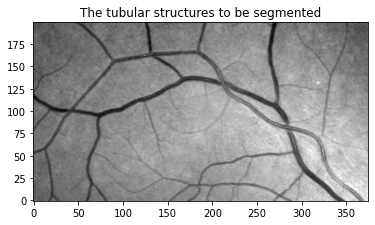

In [12]:
# Use the origin = 'lower' option for compatibility with e.g. numpy.contourf 
plt.title('The tubular structures to be segmented')
imshow(image,cmap='gray');

### 0.3 Define the points of interest

The next cell defines a number of points of interest in the image, between which some geodesics will be backtraced by the HFM library. In practical applications, these seeds and tips may be automatically generated, or user defined.

In [13]:
seeds0 = xp.array([ 
        [327, 15], #On main vessel
        [259, 14], # On small bottom vessel
    ]);

seeds1 = xp.array([
        [350, 16] # On secondary vessel
        #  [327, 92] # On small right vessel
    ]);


tips0 = xp.array([
        [291,65], #On primary vessel, easy
        [203,41], # On a small vessel, attached to the primary vessel
        [250,115], #On primary vessel, after crossing
        [116,111], #On primary vessel, possible shortcut
        [64,24], #On primary vessel, possible shortcut, far
        [12,108], #On primary vessel, two possible shortcuts
                
        [115,54] #On small bottom vessel, after crossing
    ]);

tips1 = xp.array([
        [302,77], #On secondary vessel, easy
        [244,105], #On secondary vessel, after crossing
        [189,188], #On secondary vessel, possible shortcut
        [64,189], #On secondary vessel, two possible shortcuts
        [20,25], #On secondary vessel, three possible shortcuts
        
        [304,176] #On small right vessel
    ]);

seeds = np.concatenate((seeds0,seeds1))
tips = np.concatenate((tips0,tips1))

In this notebook, we always use an image origin at the point $(0,0)$, and a unit physical grid scale. In other words, the side of a pixel has length $1$. As a result, the (multi-)indices of the seeds and tips in the data arrays are also their 'physical' coordinates. In case of more general coordinate systems, such as In the other notebooks of this series, the conversion between physical points and array indices is performed using the HFM library and the keys 'pointToIndex' and 'indexToPoint'.

In [14]:
seedIndices0, seedIndices1, seedIndices = seeds0.astype(int), seeds1.astype(int), seeds.astype(int)
tipIndices0, tipIndices1, tipIndices = tips0.astype(int), tips1.astype(int), tips.astype(int)

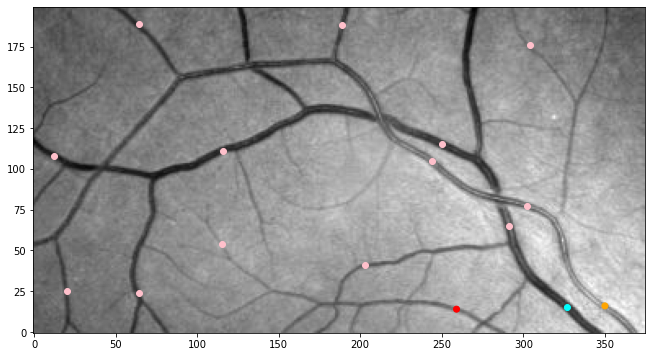

In [15]:
plt.figure(figsize=(12,6))
plt.scatter(seeds[:,0],seeds[:,1],color=['cyan','red','orange']) # Seeds in red
plt.scatter(tips[:,0],tips[:,1],color='pink') # Tips in blue
imshow(image,cmap='gray');

We attach one distinct color to each seed, that will be used for coloring the backtracked geodesics.

In [16]:
def SeedColor(pt):
    seedIndex = np.argmin((seeds[:,0]-pt[0])**2+(seeds[:,1]-pt[1])**2)
    return ['cyan','red','orange'][seedIndex]
# Named colors : 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'

## 1. Preliminary image filtering

The demonstrated approach to image processing and tubular structure extraction works in two steps:
* A *local* step, during which the processed image is analyzed locally so as to  local filters, durin
* A second *global* 

Two steps are required

### 1.1 Gabor-like filters

We use local filters to detect, in a preliminary image filtering, wether a vessel or the edge of an object is likely present at a point of the provided image. They are closely related with the Gabor filter, up to an additional anisotropy parameter. These convolution kernels depend on several parameters
* $\theta$, the orientation of the object to be detected.
* $r$, the radius of the vessel to be detected. 
* the anisotorpy, i.e. elongation, of the kernel.
* wether vessels appear clearer or darker than the background. In the image considered, they are darker.

The following function returns a local system of coordinates $(X,Y)$ in the plane, a Gaussian bump, and two convolution filters that are closely related with the real and imaginary part of a Gabor filter. They can be used to detect, respectively, tube-like features and object boundaries.

<!---ExoFR
Implémentez le *mean filter*, *vessel filter*, et *edge filter* qui sont définis par 
$$
    m(x,y) = \frac 1 Z \exp(-\frac{x_r^2}{2\mu^2} - \frac{y_r^2} 2)
    \qquad
    v(x,y) = m(x,y) \cos(2 y_r) - \underline v
    \qquad
    e(x,y) = m(x,y) \sin(2 y_r)
$$
où $Z$ est une constante de normalisation, $\mu$ est le ratio d'anisotropie désiré, et $\underline v$ est tel que $v$ est de moyenne nulle. Le repère $(x_r,y_r)$ est l'image des coordonnées cartésiennes $(x,y)$ par rotation d'angle $-\theta$ et scaling par $1/r$ donné.
--->

<!---ExoCode
def FeatureKernels(radius, theta, anisotropy, darkObjects = False):
    # Construct coordinate system
    side = int(radius * anisotropy * 1.4)+1
    ran = xp.arange(-side,side+1)
    X,Y = xp.meshgrid(ran,ran,indexing='ij')  
    
    # Rotate and rescale the coordinate system
    Xr,Yr = # TODO rotation d'angle -theta, multiplication par 1/radius
     
    # Mean filter
    bump =  # TODO Anisotropic gaussian. Voir expression plus haut
    bump = bump/bump.sum() # Normalized bump function
    
    # Other filters
    edge = # TODO 
    vessel = # TODO. Doit être de moyenne nulle.
    
    sign= -1 if darkObjects else 1
    return [X, Y, bump, sign*vessel, sign*edge] 
--->

In [17]:
def FeatureKernels(radius, theta, anisotropy, darkObjects = False):
    # Construct coordinate system
    side = int(radius * anisotropy * 1.4)+1
    ran = xp.arange(-side,side+1)
    X,Y = xp.meshgrid(ran,ran,indexing='ij')  
    
    # Rotate and rescale the coordinate system
    Xr,Yr = np.cos(theta)*X+np.sin(theta)*Y, -np.sin(theta)*X+np.cos(theta)*Y
    Xr,Yr = Xr/radius, Yr/radius
    
    bump = np.exp(-((Xr/anisotropy)**2+Yr**2)/2) # Anisotropic gaussian
    bump = bump/bump.sum() # Normalized bump function
    
    #Constant 2 is somewhat arbitrary
    edge = bump*np.sin(2*Yr); # Similar to imaginary part of Gabor filter
    vessel = bump*np.cos(2*Yr); # Similar to real part of Gabor filter
    vessel = vessel - vessel.sum() * bump # Filter should have zero mean.
    
    sign= -1 if darkObjects else 1
    return [X, Y, bump, sign*vessel, sign*edge] 

In [18]:
X, Y, meanFilter, vesselFilter, edgeFilter = FeatureKernels(3,np.pi/6,2,darkObjects=True)

The first filter, the *vessel filter*, is efficient at detecting (the centerline of) tubular structures, which radius and orientation match the parameters.

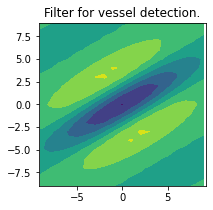

In [19]:
fig = plt.figure(figsize=[3,3]); plt.title('Filter for vessel detection.');
plt.contourf(X,Y,vesselFilter); plt.axis('equal'); 

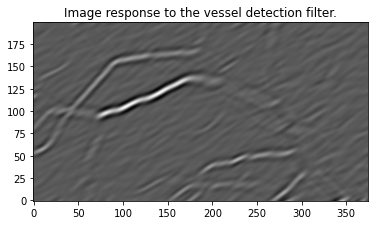

In [20]:
plt.title('Image response to the vessel detection filter.');
imshow(ndimage.convolve(image,vesselFilter),cmap='gray'); #plt.colorbar();

The second filter can be used to detect object boundaries. This is irrelevant for the present application. For instance, two cells below, we obtain a positive and a negative reponse on the side of the vessel, which radius and orientation match the parameters. In contrast the previous filter yields a positive response in the vessel centerline, which is of direct interest.

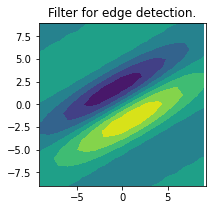

In [21]:
fig = plt.figure(figsize=[3,3]); plt.title('Filter for edge detection.'); 
plt.contourf(X,Y,edgeFilter); plt.axis('equal'); 

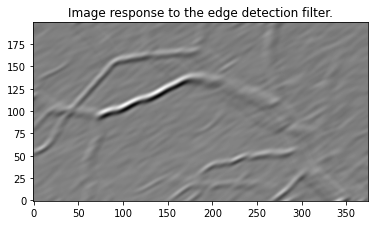

In [22]:
plt.title('Image response to the edge detection filter.');
imshow(ndimage.convolve(image,edgeFilter),cmap='gray');

### 1.2 Maximization over radii and/or orientations

In this subsection, we compute the response of the image to the Gabor-like filters for various orientation and radius parameters.

Our first step is to choose the kernel parameters. We fix the anisotropy of the kernel, and define a discretization space for the radius and orientation.

In [23]:
kernelAnisotropy = 2

In [24]:
nHalfTheta = 30
Thetas = np.linspace(0,np.pi,nHalfTheta,endpoint=False) # 30 angular orientations in [0,\pi]

In [25]:
radiusMin = 1.2; radiusMax = 5; nRadius = 5;
Radii = np.exp(np.linspace(np.log(radiusMin),np.log(radiusMax),nRadius))
#Radii = np.geomspace(radiusMin,radiusMax,nRadius) # Equivalent, but geomspace is not found on my computer

In [26]:
print(Radii,"\n",Thetas)

[1.2        1.71446426 2.44948974 3.49963551 5.        ] 
 [0.         0.10471976 0.20943951 0.31415927 0.41887902 0.52359878
 0.62831853 0.73303829 0.83775804 0.9424778  1.04719755 1.15191731
 1.25663706 1.36135682 1.46607657 1.57079633 1.67551608 1.78023584
 1.88495559 1.98967535 2.0943951  2.19911486 2.30383461 2.40855437
 2.51327412 2.61799388 2.72271363 2.82743339 2.93215314 3.0368729 ]


In the next cell, we convolve the input image with the chosen Gabor-like filters. 
The resulting array is $4$-dimensional, with the following coordinate system: $(r,\theta,x,y)$.
A multiplicative factor factor $1/\sqrt r$ is introduce so as to slightly increase the visibility of vessels of small radius $r$.

In [27]:
# Note : takes a few seconds
import time; start_time = time.time()

response = np.array([[ 
ndimage.convolve(image, FeatureKernels(radius,theta,kernelAnisotropy,darkObjects=True)[3] )/ np.sqrt(radius)
                      for theta in Thetas] for radius in Radii])

print("--- %s seconds ---" % (time.time() - start_time))

--- 4.33413290977478 seconds ---


The above computed $4$ dimensional response array is in a sense *too high dimensional* for most applications.
Indeed, in order to keep execution times low and to user experience good, most PDE-based numerical for image processing methods involve domains of dimension $2$ or $3$ only.  In the next cell, we perform dimension crushing by taking the maximum of the filter response w.r.t. radius, angle, or both.

In [28]:
responseRadius = response.max(axis=1).transpose(1,2,0) # Radius dependent response
responseTheta = response.max(axis=0).transpose(1,2,0) # Orientation dependent response
response0 = responseRadius.max(axis=2) # Position only dependent response

In [29]:
print('Original image size',response0.shape,', radius lifted:',responseRadius.shape,
      ', orientation lifted',responseTheta.shape,'.')

Original image size (375, 200) , radius lifted: (375, 200, 5) , orientation lifted (375, 200, 30) .


The next figure shows the maximum of the image response to the Gabor-like filter over orientations and radii. We regard this as a *measure of vesselness*.

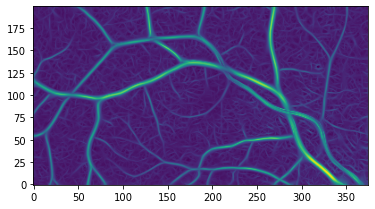

In [30]:
imshow(response0); #plt.colorbar();

The radius-dependent response does, as expected and desired, detect large vessels at large scales and small vessels at small scales.

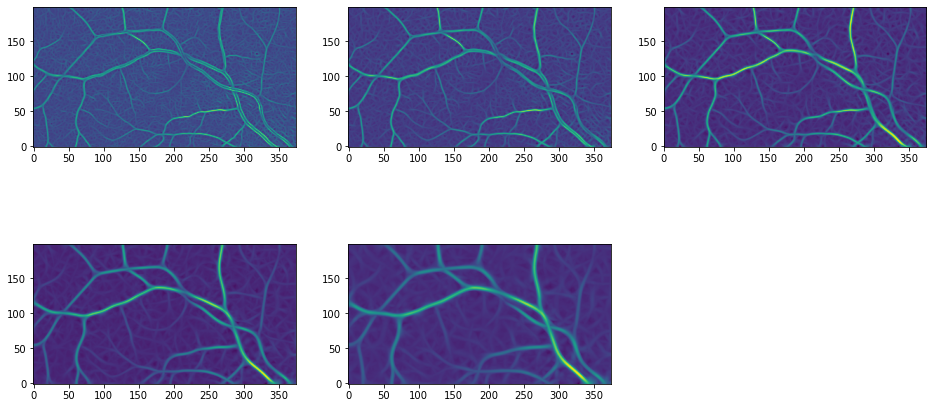

In [31]:
plt.figure(figsize=(16,8))
for i in range(5):
    plt.subplot(2,3,1+i)
    imshow(responseRadius[:,:,i]);

The orientation-dependent response is positive only for the vessels parts whose orientation matches the one of the filter.

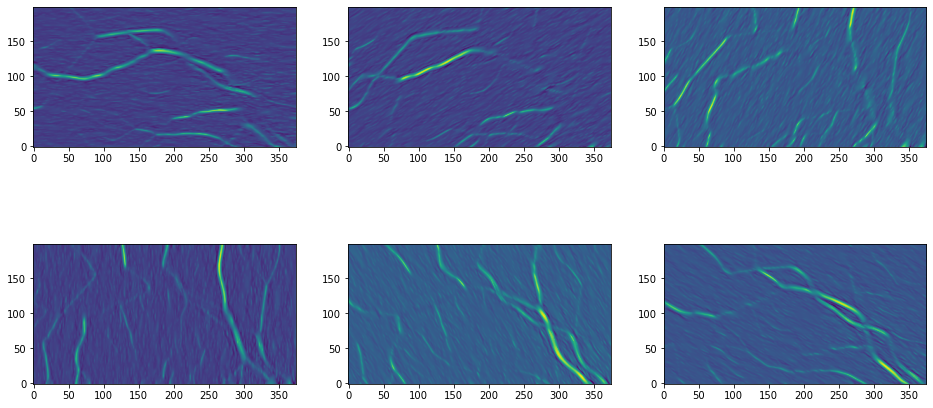

In [32]:
plt.figure(figsize=(16,8))
for i in range(6):
    plt.subplot(2,3,1+i)
    imshow(responseTheta[:,:,int(nHalfTheta*i/6)]);

In [33]:
#fig=plt.figure(figsize=(6,3.5));  plt.axis('off')
#imshow(responseTheta[:,:,5]); plt.title(r'Vessel detection at orientation $\theta=\pi/6$');
#imshow(responseTheta[:,:,0]); plt.title(r'Vessel detection at orientation $\theta=0$');
#savefig(fig,'VesselDetection1.png');

In [34]:
#fig=plt.figure(figsize=(6,3.5));  plt.axis('off')
#imshow(responseRadius[:,:,0]); plt.title(r'Vessel detection at minimal radius');
#imshow(responseRadius[:,:,3]); plt.title(r'Vessel detection at maximal radius');
#savefig(fig,'VesselRadius1.png');

## 2. Isotropic models

In this section, we demonstrate vessel extraction using *isotropic* fast marching methods, an method introduced by Cohen and Kimmel (1997). The tubular structure centerlines are extracted as minimal paths, joining the prescribed seeds and tips, with respect to a metric that is locally proportionnal to the euclidean one:
\begin{equation*}
    \mathrm{len}(\gamma) = \int_0^1 c(\gamma(t)) \| \gamma'(t)\| \, \mathrm d t,
\end{equation*}
where $c$ is a data driven cost function. Let us immediately acknowledge that the HFM library is only one of the many available software which can address this particularly simple model, in contrast with the curvature penalized methods discussed in the next section. 

We also illustrate some the concept of dimension lifting, in which an additional abstract coordinate is introduced, independent from the image coordinates, that accounts for a specific feature of the vessel to be extracted. More precisely, we illustrate dimension lifting according to the extracted vessel (Li-Yezzi, 2007), and grayscale value (Chen-Yang-Cohen, 2013). In this case, the metric is usually not isotropic but, *diagonal*, which means that motion along different coordinate axes may have distinct costs. However this raises no additional computational difficulty.

**Choice of origin.**
There is a shift of one half pixel between the imshow display function and the internal representations of the eikonal solver. For this reason, the `origin` is shifted by one half pixel, for the best overlay of the image and minimal geodesic paths.

In [35]:
isoIn=Eikonal.dictIn({
    'model':'Isotropic2',
    'dims':image.shape,
    'gridScale':1,
    'exportValues':1,
    'origin':[-0.5,-0.5], #Better alignement with imshow
})

### 2.1 Planar shortest paths

In the previous section, we convolved the input image with Gabor-like filters, so as to extract a measure of vesselness. As illustrated in the next cell, vessels appear as positive values in the processed image.

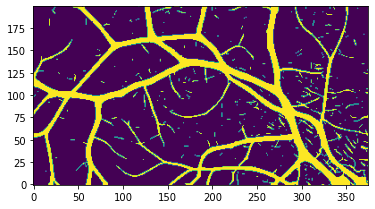

In [36]:
imshow(response0>0.01);

In the next cells, we define a cost function as the negative exponential of the previous measure of vesselness, following the original Cohen and Kimmel model. The cost function reads
$$
    c(x) = c_{\min} + \exp(-c_{\exp} \Phi_0(x)),
$$
where $c_{\min}$ and $c_{\exp}$ are two constants, and $\Phi_0(x)=$`response0(x)` is the vesselness measure maximized over all radii and orientations.

<!---ExoFR
Implementer cette fonction de coût, avec $c_{\min}=0.1$, $c_{\exp} = 50$.
--->

<!---ExoCode
isoIn['cost']= # TODO
--->

In [37]:
isoMin = 0.1
isoExp = 50 
isoIn['cost']= isoMin+np.exp(-isoExp*response0)

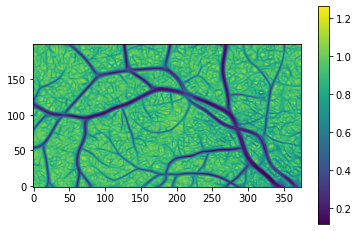

In [38]:
imshow(isoIn['cost']); plt.colorbar();

In the next cells, we perform front propagation and geodesic backtracking from the first two seeds, towards the corresponding tips. For these endpoints and parameters, the results are rather satisfying.

In [39]:
isoIn['seeds']=seeds0
isoIn['tips']=tips0

In [40]:
isoOut = isoIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.022058 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


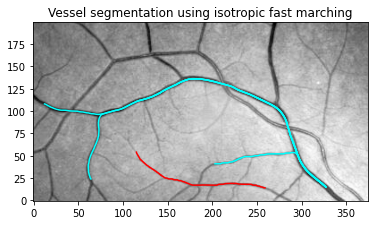

In [41]:
plt.title("Vessel segmentation using isotropic fast marching")
for geo in isoOut['geodesics']: plt.plot(*geo,color=SeedColor(geo[:,-1])) 
imshow(-image,cmap='Greys');

Recall that the geodesics presented above were backtracked after a front was propagated over all the domain, so as to compute a distance map to the seeds.

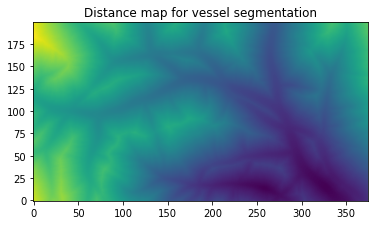

In [42]:
plt.title("Distance map for vessel segmentation")
imshow(isoOut['values']);

The front propagation is much faster along the vessels, as illustrated by the level sets.

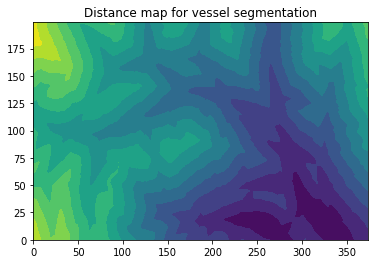

In [43]:
plt.title("Distance map for vessel segmentation")
plt.contourf(isoOut['values'].T,levels=12);

The correct extraction of the tubular structures obtained above is in part due to the favorable configuration of the seeds and tips. Turning to the second set of endpoints, we immediately see the shortcomings of the original Cohen and Kimmel model.

In [44]:
isoIn['seeds']=seeds1
isoIn['tips']=tips1

In [45]:
isoOut = isoIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.033936 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


Several issues can be identified:
* Leaks: the minimal paths often leave the vessel tree for a short while so as to join another vessel (typically more visible and contrasted).
* Shortcuts: if some vessels cross two times or more, then the backtracked minimal paths may take shortcuts by jumping from one to other vessel at their intersections.

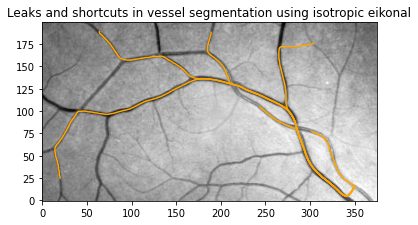

In [46]:
#plt.figure(figsize=(16,8))
plt.title("Leaks and shortcuts in vessel segmentation using isotropic eikonal")
for geo in isoOut['geodesics']: plt.plot(*geo,color=SeedColor(geo[:,-1])) 
imshow(-image,cmap='Greys');

### 2.2 Radius lifted metrics

Radius lifting is a dimension lifting technique introduced by Li and Yezzi (2007). The radius of the tubular structures is extracted simultaneously with its position, using a three dimensional fast marching method. The vessel radius is often an important feature for medical diagonostic, hence having a reliable and mathematically well posed estimation method is a real plus. 

In principle, dimension lifting techniques such as this one may also help segmentation in difficult configurations, such as the one displayed above, by disentangling the intersecting vessels in the higher dimensional domain. Unfortunately, such improvement is noticeable here, see the next subsection for a more successful approach.

In [47]:
nR = Radii.size

In [48]:
radIn=Eikonal.dictIn({
    'model':'Diagonal3',
    'dims':(*image.shape,nR),
    'gridScale':1,
    'origin':[-0.5,-0.5,-0.5]
})

In the next cell, we define the diagonal cost of motion for our minimal path model, at any point $(x,y,r)$. We choose to distinguish:
* motion along the physical coordinates, with velocity $(\dot x,\dot y,0)$, whose cost is defined as a decreasing function of the image vesselness map (maximized over orientations but not over radii). 
* motion along the abstract radius coordinate, with velocity $(0,0,\dot r)$, whose cost is set constant.

In other words, we use the diagonal metric
$$
    \begin{pmatrix}
        c(x,r) & &\\
        & c(x,r) &\\
        & & c_r 
    \end{pmatrix}
    \qquad \text{où} \quad
    c(x,r) = c_{\min} + \exp(-c_{\exp} \Phi_{\text{rad}}(x,r)),
$$
where $c_{\min}$ and $c_{\exp}$ are constants, and $\Phi_{\text{rad}}(x,r)$=`responseRadius(x,r)` is the vesselness measure maximized over orientations.

<!---ExoFR
Implémenter la métrique "diagonale" correspondant décrite ci-dessus, avec toujours $c_{\min}=0.1$, $c_{\exp}=50$. On prendra $c_r = 2$.
--->

<!---ExoCode
radIn['metric'] = Metrics.Diagonal([ # TODO : les trois coefficients diagonaux D1,D2,D3
--->

In [49]:
radMin = 0.1
radExp = 50
physCost = radMin+np.exp(-radExp*responseRadius) # Cost of motion in the physical domain
radIn['metric'] = Metrics.Diagonal([physCost,physCost,2*np.ones(physCost.shape)])

The seeds and tips must now be defined as points of a three dimensional domain. For a given physical position $(x,y)$, we choose to lift the seed or tip to the radius $r$ which minimizes the cost function. This is, if we did well, the most likely radius of the vessel at this point.

In [50]:
radIn['seeds'] = MyArgmin(seeds0,seedIndices0,physCost,range(nR))
radIn['tips'] = MyArgmin(tips0,tipIndices0,physCost,range(nR))

In [51]:
radOut = radIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.206689 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


The segmentation results remain correct for the first set of seeds and tips, and incorrect for the second one (not shown).

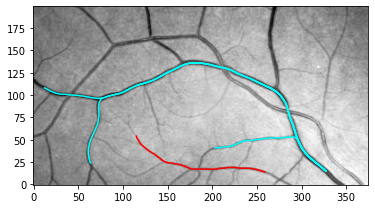

In [52]:
for geo in radOut['geodesics']: plt.plot(geo[0],geo[1],color=SeedColor(geo[:,-1])) 
imshow(-image,cmap='Greys');

However, some new information is extracted from the image: the radius of the backtraced vessels, as illustrated in the following figure. For that purpose, we need to convert radii from the linear scale used with the HFM library to  the original exponential scale.

In [53]:
def PhysRadius(r): return Radii[0]*(Radii[1]/Radii[0])**r
print(Radii,'\n',[PhysRadius(r) for r in range(nR)])

[1.2        1.71446426 2.44948974 3.49963551 5.        ] 
 [1.2, 1.7144642578192795, 2.4494897427831774, 3.4996355115805815, 4.999999999999997]


Note : Correctly setting the *pix2pt* conversion factor in the next code snippet, from input image pixels to displayed image points, would involve a complex expression involving dpi, inches, images pixel size, ...

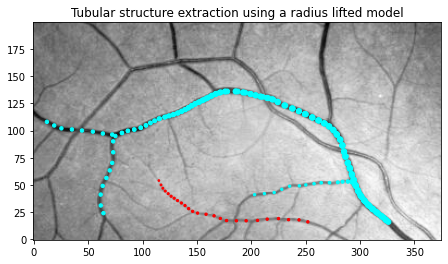

In [54]:
pix2pt=1.4
fig = plt.figure(figsize=(8,4))
plt.title('Tubular structure extraction using a radius lifted model')
for geo in radOut['geodesics']: 
    pts=geo[:,::10] #subsampling to make the vessel visible
    plt.scatter(pts[0],pts[1],s=pix2pt**2*PhysRadius(pts[2])**2,marker='o',color=SeedColor(geo[:,-1])) 
imshow(-image,cmap='Greys');
savefig(fig,'VesselRadius.png');

The extracted geodesics are genuine three dimensional paths.

/var/folders/my/8txl5p_52rj9jc_601wqr7cr0000gn/T/ipykernel_93074/3007447941.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  fig = plt.figure(); ax = fig.gca(projection='3d')


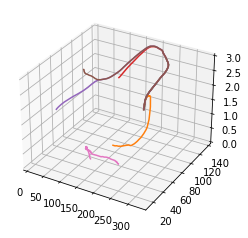

In [55]:
fig = plt.figure(); ax = fig.gca(projection='3d')
for geo in radOut['geodesics']: ax.plot(*geo)

### 2.3 Gray-level consistency

A second dimension lifting technique is discussed in this subsection, involving the grayscale value of the extracted vessel, following Cohen and Chen (2013). Indeed, distinct vessels often have distinct gray levels, and this feature varies rather slowly along the vessel. (In particular, veins and arteries have different colors.) Thus it can be used to disentangle the vessels, seen intersecting in the original image, in an abstract three dimensional space.

In order to obtain locally consistent grayscale values, we slightly blur the input image.

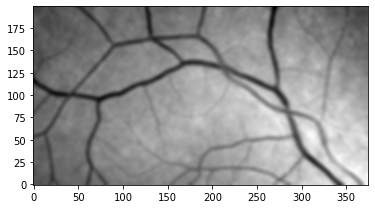

In [56]:
grayRef = ndimage.convolve(image, FeatureKernels(2,0,1)[2] )
imshow(grayRef,cmap='gray');

We build in the next cell a scale consisting of $20$ gray intensities in the range $[0.2,0.7]$. Note that we could have instead discretized whole brightness interval $[0,1]$, but limiting ourselves to the sub-range actually encountered for the vessels saves a bit of computation time.

In [57]:
grayMin = 0.2
grayMax = 0.7
grayN = 40
grayScale = (grayMax-grayMin)/grayN
grayLevels = Eikonal.CenteredLinspace(grayMin,grayMax,grayN)

The cost function, for motions $(\dot x, \dot y, 0)$ along the physical dimensions, is defined as follows:
$$
    c(x,y,g) = c_0(x,y) \left(1+ \frac{(g-G(x,y))^2}{2 \sigma^2}\right).
$$
We denoted by $g$ the coordinate in the extra 'grayscale' dimension, and by $G$ the slightly blurred image used as grayscale reference. We denoted by $c_0$ the cost function used in the experiment with the classical Cohen and Kimmel model, and by $\sigma>0$ a standard deviation in the grayscale dimension that is to be determined. By construction, this cost strongly increases when the current grayscale value differs from the image reference by more than $\sigma$.

<!---ExoFR
Produire un tableau numpy correspondant à la fonction coût ci-dessus.
--->

<!---ExoCode
baseMin = 0.1
baseExp = 50
baseCost = baseMin+np.exp(-baseExp*response0) # c_0(x,y)

graySigma = 3*grayScale
grayCost = # TODO
--->

In [58]:
baseMin = 0.1
baseExp = 50
baseCost = baseMin+np.exp(-baseExp*response0) 

graySigma = 3*grayScale
grayCost = np.stack([baseCost*(1+(grayRef-lvl)**2 / (2*graySigma**2) ) for lvl in grayLevels],axis=-1)

Some slices of the cost function, corresponding to several coordinates in the grayscale dimension, are shown in the following cell.

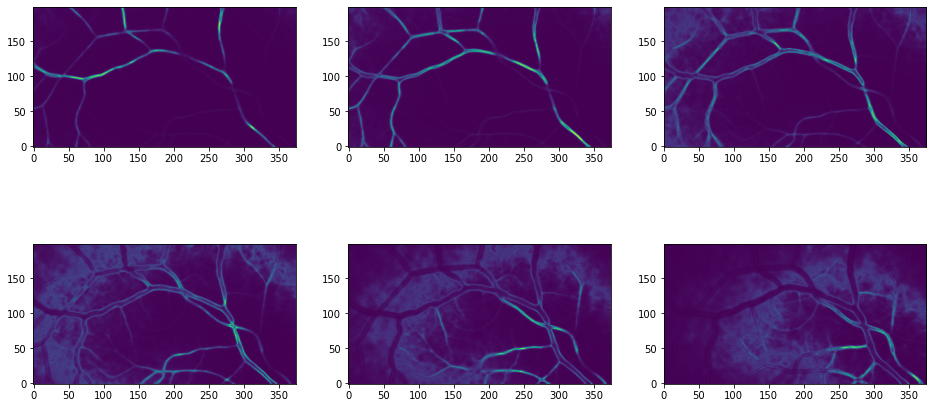

In [59]:
plt.figure(figsize=(16,8)) 
for i in range(6):
    plt.subplot(2,3,1+i)
    imshow(1/grayCost[:,:,2+6*i]);

Motions along the grayscale dimension $(0,0,\dot g)$ are penalized w.r.t. a cost inversely proportionnal with the grayscale intensity:
\begin{equation*}
    c(g) = \frac \alpha g,
\end{equation*}
where $\alpha>0$ is a suitable constant. This definition amounts to a uniform penalization in the logarithmic coordinates $g\mapsto \alpha \ln g$.

In [60]:
grayLevelCost = np.broadcast_to((100/grayLevels),(*image.shape,grayN))

We next proceed to define the test case.

In [61]:
grayIn=Eikonal.dictIn({
    'model':'Diagonal3',
    'exportValues':1,

    # Domain dimensions
    'dims':grayCost.shape,
    'gridScales':[1,1,grayScale],
    'origin':[0,0,grayMin],
    
    'metric':Metrics.Diagonal([grayCost,grayCost,grayLevelCost]),
    'seeds':MyArgmin(seeds1,seedIndices1,grayCost,grayLevels),
    'tips': MyArgmin(tips1,tipIndices1,grayCost,grayLevels)
})
grayIn['stopWhenAllAccepted'] = grayIn['tips']

In [62]:
grayOut = grayIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 2.4868 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


As shown in the next cell, the backtraced minimal path is now correct for four tips out of six, shown as pink disks. In contrast, only a single backtracking was successful in the previous experiments, corresponding to the tip closest to the seed.

Note that the planar projections of several of the backtracked paths cross each other. This phenomenon is a signature of dimension lifting techniques.

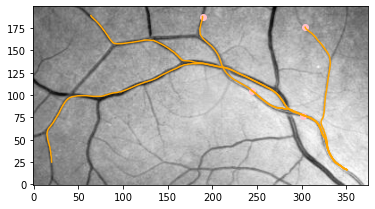

In [63]:
plt.scatter(tips1[0:3,0],tips1[0:3,1],color='pink');
plt.scatter(tips1[5,0],tips1[5,1],color='pink');
for geo in grayOut['geodesics']: plt.plot(geo[0],geo[1],color=SeedColor(geo[:,-1])) 
imshow(-image,cmap='Greys');

We can help the tubular structure extraction by exchanging the roles of the seed and of the third tip. 

In [64]:
grayIn['tips'][2,:],grayIn['seeds'][0,:]=deepcopy(grayIn['seeds'][0,:]),deepcopy(grayIn['tips'][2,:])

In [65]:
grayOut = grayIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.55624 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


All extracted minimal geodesic now run along the secondary gray vessel, as desired, with the exception of the faint side vessel on the right.

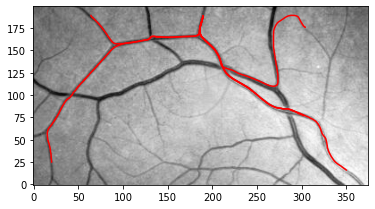

In [66]:
for geo in grayOut['geodesics']: plt.plot(geo[0],geo[1],color=SeedColor(geo[:,-1])) 
imshow(-image,cmap='Greys');

Regarding the first set of seeds and tips, the vessel extraction remains successful, except for a small error in the bottom, arguably excusable given the type of models considered.

In [67]:
grayIn['seeds']= MyArgmin(seeds0,seedIndices0,grayCost,grayLevels)
grayIn['tips'] = MyArgmin(tips0,tipIndices0,grayCost,grayLevels)

In [68]:
grayOut = grayIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 2.05014 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
Tip {12,108,0.20625} yields 7 restarts, geodesicVolumeBound increased to 24.134

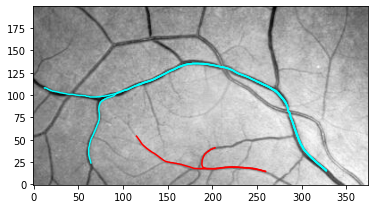

In [69]:
for geo in grayOut['geodesics']: plt.plot(geo[0],geo[1],color=SeedColor(geo[:,-1])) 
imshow(-image,cmap='Greys');

## 3. Curvature penalized models

This section is devoted to tubular segmentation using minimal paths with respect to curvature penalizing energies, of the form
\begin{equation*}
    \int_0^L c(\gamma(t), \gamma'(t)) \mathcal C(\gamma''(t)) \mathrm d t,
\end{equation*}
where $\gamma$ is a path in the image domain, of euclidean length $L$ and parametrized at unit speed.
The intent of curvature penalization is to add some "inertia" to the geodesics, so that they do not switch from one tubular structure to another at crossings, thus avoiding the problem of "shortcuts".
The HFM library rephrases this second order energy into a first order path length with respect to a degenerate metric, and computes a global optimum using a generalized fast marching algorithm.

The cost function involved in curvature penalized models depends on both the current position and orientation of the path. We denote it $c(x,\theta)$, abusively identifying the unit tangent vector with the corresponding angle. The next cell defines such a cost function, as a negative exponential of the input image response to the Gabor-like convolution filters.
$$
    c(x,\theta) = c_{\min} + \exp(-c_{\exp} \Phi(x,\theta)),
$$
where $c_{\min}$ and $c_{\exp}$ are positive constants, and $\Phi$ is the vesselness map, maximized over radii.


<!---ExoFR
Implémenter cette fonction coût, sous la forme d'un tableau numpy, avec $c_{\min}=0.1$, $c_{\exp}=100$.
--->

<!---ExoCode
orientedCost = # TODO
--->

In [70]:
orientedCost = 0.1+np.exp(-100*responseTheta)

The seeds and tips, originally defined as points of the image domain, must be lifted to three dimensional configuration space of positions and orientations.
We do this by selecting the orientation angle minimizing the cost function, at any given position. Alternatively, one could resort to the "seeds_Unoriented" and "tips_Unoriented" fields when calling the HFM library.

In [71]:
orientedSeeds = MyArgmin(seeds,seedIndices,orientedCost,Thetas)
orientedTips = MyArgmin(tips,tipIndices,orientedCost,Thetas)

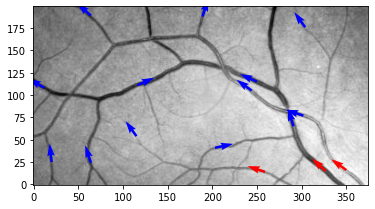

In [72]:
imshow(-image,cmap='Greys');
plt.quiver(seeds[:,0],seeds[:,1],np.cos(orientedSeeds[:,2]),np.sin(orientedSeeds[:,2]),color='red')
plt.quiver(tips[:,0],tips[:,1],np.cos(orientedTips[:,2]),np.sin(orientedTips[:,2]),color='blue');

Note that the above definition of the oriented cost and lifted seeds and tips assumes an angular variable $\theta \in [0,\pi]$ defined up to a multiple of $\pi$. Some models require the full specification $\theta \in [0,2\pi]$ of an orientation and a direction, but not the first one that we consider.

### 3.1 The Reeds-Shepp model

The Reeds-Shepp "car" model would be a suitable abstraction for a wheelchair or a Segway&reg;-like vehicle. In particular, such vehicles can rotate into place for a bounded cost, and move both forward and backwards. From a mathematical standpoint, the Reeds-Shepp model is one of the most studied, thanks to its appealing sub-Riemannian structure. The function $\mathcal C$ used to penalize the path curvature $\kappa = \|\gamma''(t)\|$ is defined by
\begin{equation*}
    \mathcal C(\kappa) := \sqrt{1+ \xi^2 \kappa^2},
\end{equation*}
where $\xi$ is a parameter defined by the user, which has the dimension of a radius of curvature.

A variant, referred to as the Reeds-Shepp *forward* model, implemented in the HFM library but not further discussed here, allows to remove the reverse gear.

In [73]:
reedsIn = Eikonal.dictIn({
    'model':'ReedsShepp2',
    'projective':1, # Angular coordinates are restricted to the (periodic) interval [0,pi]
    'xi':40,
    
    'dims':(*image.shape,nHalfTheta),
    'gridScale':1, # Physical grid scale (not angular)
    'cost':orientedCost,
})

For the first set of seeds and tips, the Reeds-Shepp model extracts the desired vessels.

In [74]:
reedsIn['seeds']= MyArgmin(seeds0,seedIndices0,reedsIn['cost'],Thetas)
reedsIn['tips'] = MyArgmin(tips0, tipIndices0, reedsIn['cost'],Thetas)
reedsIn['stopWhenAllAccepted']=reedsIn['tips']

In [75]:
reedsOut = reedsIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.6444 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


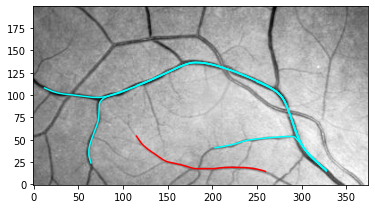

In [76]:
for geo in reedsOut['geodesics']: plt.plot(geo[0],geo[1],color=SeedColor(geo[:,-1])) 
imshow(-image,cmap='Greys');

For the second, harder, collection of seeds and tips, the Reeds-Shepp model extract the desired vessels in when backtracking from four tips, similarly to the grayscale lifted method, and much better than the isotropic or radius lifted approaches (one tip). Observe that some of (the planar projections of) the backtracked geodesics cross each other, which we recall is a signature of dimension lifting techniques. 

In [77]:
reedsIn['seeds']= MyArgmin(seeds1,seedIndices1,reedsIn['cost'],Thetas)
reedsIn['tips'] = MyArgmin(tips1,tipIndices1,reedsIn['cost'],Thetas)
reedsIn['stopWhenAllAccepted']=reedsIn['tips']

In [78]:
reedsOut = reedsIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 2.39527 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


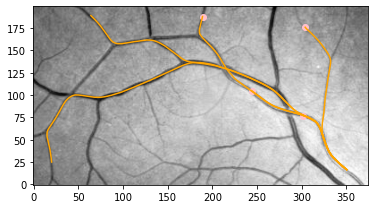

In [79]:
plt.scatter(tips1[0:3,0],tips1[0:3,1],color='pink');
plt.scatter(tips1[5,0],tips1[5,1],color='pink');
for geo in reedsOut['geodesics']: plt.plot(geo[0],geo[1],color=SeedColor(geo[:,-1])) 
imshow(-image,cmap='Greys');

Similarly to the grayscale lifted case, we can help the backtracking by exchanging the role of the seed and a of the third tip.

In [80]:
reedsIn['tips'][2,:],reedsIn['seeds'][0,:]=deepcopy(reedsIn['seeds'][0,:]),deepcopy(reedsIn['tips'][2,:])

In [81]:
reedsOut = reedsIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 2.52695 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


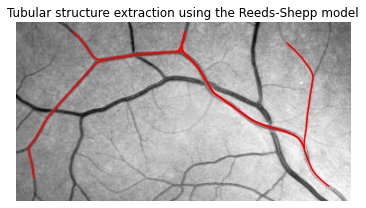

In [82]:
fig=plt.figure(figsize=(6,3.5));  plt.axis('off'); plt.title('Tubular structure extraction using the Reeds-Shepp model')
for geo in reedsOut['geodesics']: plt.plot(geo[0],geo[1],color=SeedColor(geo[:,-1])) 
imshow(-image,cmap='Greys');
savefig(fig,'ReedsSheppBacktracking.png')

Note the cusp, in other words the regression point, in the trajectory leading to the faint vessel on the right. In this case, and contrary to often, the cusp appears to be meaningful and well placed. Cusps can be regarded as a signature of sub-Riemannian models.

### 3.2 The Euler-Mumford elastica model

This model distinguishes itself by two points from the previously mentioned Reeds-Shepp car:
* The absence of a reverse gear. The vehicle cannot move backwards, or even stop to rotate into place.
* The stronger penalization of curvature, based on cost
\begin{equation*}
    \mathcal C(\kappa) := 1+\xi^2 \kappa^2,
\end{equation*}
where again $\xi$ is a user provided parameter. This cost has the physical interpretation of the bending energy of an elastic bar, hence the name.

The Euler-Mumford elastica model is a bit costly in terms of computation time, but it often yields the most satisfying results.

In [83]:
eulerIn=Eikonal.dictIn({
    'model':'Elastica2',
    'xi':60,
    'dims':(*image.shape,2*nHalfTheta),
    'gridScale':1,
})

The angular coordinate $\theta$ belongs to the full interval $[0,2 \pi]$, and not $[0,\pi]$ as in our previous experiment. In more precise mathematical terms, the Euler-Mumford elastica is posed on the configuration space $\mathbb R^2 \times \mathbb S^1$, in contrast with the projective Reeds-Shepp model discussed above which is defined on $\mathbb R^2 \times \mathbb P^1$.
As a result, the array defining the cost function must be duplicated. 

<!---ExoFR
Construire le tableau de coûts du modèle Euler Elastica, sur $R^2 \times S^1$, à partir de celui conçu pour Reeds-Shepp non-orienté, sur $R^2 \times P^1$. Noter que $P^1 \approx [0,\pi[$ avec conditions au bord périodiques, et $S^1 \approx [0,2\pi[ = [0,\pi[ \cup [\pi,2 \pi[$. On répètera donc les entrées de coût sur le second intervalle angulaire. 
--->

<!---ExoCode
eulerIn['cost'] = # TODO. Hint np.concatenate, involves orientedCost
--->

In [84]:
eulerIn['cost']=np.concatenate((orientedCost,orientedCost),axis=2)

For our first trial, we lift the seeds and tips to the orientation domain using the same routine as for the projective Reeds-Shepp model. As shown below, this attempt is a complete failure.

In [85]:
eulerIn['seeds']= MyArgmin(seeds0,seedIndices0,orientedCost,Thetas)
eulerIn['tips'] = MyArgmin(tips0, tipIndices0, orientedCost,Thetas)
eulerIn['stopWhenAllAccepted']=eulerIn['tips']

In [86]:
%%time
# Warning : takes up to a minute.
eulerOut =eulerIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 16.937 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
CPU times: user 219 ms, sys: 101 ms, total: 319 ms
Wall time: 18.4 s


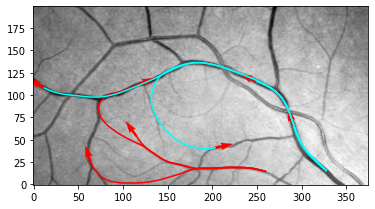

In [87]:
plt.quiver(eulerIn['tips'][:,0],eulerIn['tips'][:,1],np.cos(eulerIn['tips'][:,2]),np.sin(eulerIn['tips'][:,2]),color='red')
for geo in eulerOut['geodesics']: plt.plot(geo[0],geo[1],color=SeedColor(geo[:,-1])) 
imshow(-image,cmap='Greys');

The geodesics could not be successfully backtracked because their endpoints were not correctly oriented.
There are two possible remedies to this situation:
* 1- reverse the direction of the culprits.
* 2- forget about the orientation of the tips altogether.

The same reasoning applies to the seed points, but they are here, by chance, correctly oriented.

In [88]:
for i in [1,3,4]: eulerIn['tips'][i,2]+=np.pi # Solution 1 : reverse the direction of ill oriented tips.
eulerIn['tips_Unoriented'] = tips0 # Solution 2 : forget about the tips orientation
eulerIn['stopWhenAllAccepted']=eulerIn['tips']

Note that the computation time is several times is shorter. That is because the tips (correctly oriented, or unoriented) are reached earlier, hence the front propagation can be aborted sooner.

In [89]:
%%time
# Warning : takes up to a minute.
eulerOut = eulerIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 2.4166 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
CPU times: user 295 ms, sys: 111 ms, total: 406 ms
Wall time: 3.53 s


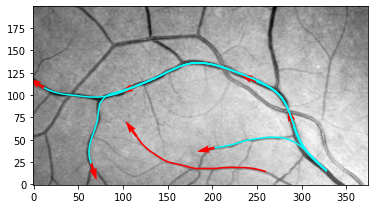

In [90]:
# With correctly oriented tips
plt.quiver(eulerIn['tips'][:,0],eulerIn['tips'][:,1],np.cos(eulerIn['tips'][:,2]),np.sin(eulerIn['tips'][:,2]),color='red')
for geo in eulerOut['geodesics']: plt.plot(geo[0],geo[1],color=SeedColor(geo[:,-1])) 
imshow(-image,cmap='Greys');

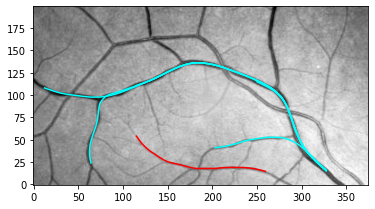

In [91]:
# With unoriented tips
for geo in eulerOut['geodesics_Unoriented']: plt.plot(geo[0],geo[1],color=SeedColor(geo[:,-1])) 
imshow(-image,cmap='Greys');

We next address the second, harder, set of seeds and tips. Sadly, and a bit surprisingly, the results are not as good as with the Reeds-Shepp model in this instance.

In [92]:
eulerIn.pop('tips_Unoriented', None);
eulerIn.pop('seeds_Unoriented',None);

In [93]:
eulerIn['seeds'] = MyArgmin(seeds1,seedIndices1,orientedCost,Thetas)

eulerIn['tips'] = MyArgmin(tips1,tipIndices1,orientedCost,Thetas)
eulerIn['tips'][4,2] += np.pi # Solution 1 : Reverse the uncorrectly oriented tip
eulerIn['stopWhenAllAccepted']=eulerIn['tips']

In [94]:
eulerOut = eulerIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 4.23154 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


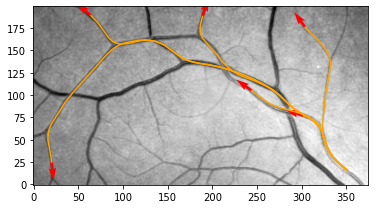

In [95]:
plt.quiver(eulerIn['tips'][:,0],eulerIn['tips'][:,1],np.cos(eulerIn['tips'][:,2]),np.sin(eulerIn['tips'][:,2]),color='red')
for geo in eulerOut['geodesics']: plt.plot(geo[0],geo[1],color=SeedColor(geo[:,-1])) 
imshow(-image,cmap='Greys');

In [96]:
eulerIn.pop('tips',None);
eulerIn.pop('seeds',None);
eulerIn.pop('stopWhenAllAccepted',None);

Trying, to exchange the roles of the seed and third tip. We set all of them unoriented for simplicity.

In [97]:
eulerIn['tips_Unoriented']=deepcopy(tips1)
eulerIn['seeds_Unoriented']=deepcopy(seeds1)
eulerIn['tips_Unoriented'][2,:],eulerIn['seeds_Unoriented'][0,:] \
=deepcopy(eulerIn['seeds_Unoriented'][0,:]),deepcopy(eulerIn['tips_Unoriented'][2,:])

In [98]:
eulerOut = eulerIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Fast marching solver completed in 27.0382 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


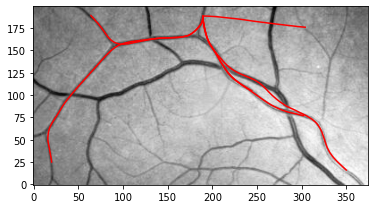

In [99]:
for geo in eulerOut['geodesics_Unoriented']: plt.plot(geo[0],geo[1],color=SeedColor(geo[:,-1])) 
imshow(-image,cmap='Greys');

In [100]:
# Use this cell to inspect the tips and reverse their orientation if necessary
#i=4
#plt.quiver(eulerIn['tips'][:,0],eulerIn['tips'][:,1],np.cos(eulerIn['tips'][:,2]),np.sin(eulerIn['tips'][:,2]),color='red')
#plt.quiver(eulerIn['tips'][i,0],eulerIn['tips'][i,1],np.cos(eulerIn['tips'][i,2]),np.sin(eulerIn['tips'][i,2]),color='blue')
#plt.imshow(-image,origin='lower',cmap='Greys');

## 4. Other models

As discussed in the introduction, many other models can be thought of, and implemented using the HFM library, for tubular structure segmentation. For instance, this notebook does not discuss at all Riemannian models, which are more flexible than isotropic or diagonal models, while being only marginally more expensive.